<a href="https://colab.research.google.com/github/dupeljan/graph_emb_lab/blob/main/DLyakhov_graph_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Node Classification without Graph Neural Networks by graph embeddings

## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random
import gensim

## Prepare the Dataset

The Cora dataset consists of 2,708 scientific papers classified into one of seven classes.
The citation network consists of 5,429 links. Each paper has a binary word vector of size
1,433, indicating the presence of a corresponding word.

### Download the dataset

The dataset has two tap-separated files: `cora.cites` and `cora.content`.

1. The `cora.cites` includes the citation records with two columns:
`cited_paper_id` (target) and `citing_paper_id` (source).
2. The `cora.content` includes the paper content records with 1,435 columns:
`paper_id`, `subject`, and 1,433 binary features.

Let's download the dataset.

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

180224/168052 [================================] - 0s 2us/step


### Process and visualize the dataset

Then we load the citations data into a Pandas DataFrame.

In [3]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


Now we display a sample of the `citations` DataFrame.
The `target` column includes the paper ids cited by the paper ids in the `source` column.

In [4]:
citations.sample(frac=1).head()

,target,source
3903,95642,990075
3654,75969,591017
844,3229,27631
1086,5062,5069
3445,63549,1105344


Now let's load the papers data into a Pandas DataFrame.

In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


Now we display a sample of the `papers` DataFrame. The DataFrame includes the `paper_id`
and the `subject` columns, as well as 1,433 binary column representing whether a term exists
in the paper or not.

Let's display the count of the papers in each subject.

In [6]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


We convert the paper ids and the subjects into zero-based indices.

In [7]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

Now let's visualize the citation graph. Each node in the graph represents a paper,
and the color of the node corresponds to its subject. Note that we only show a sample of
the papers in the dataset.

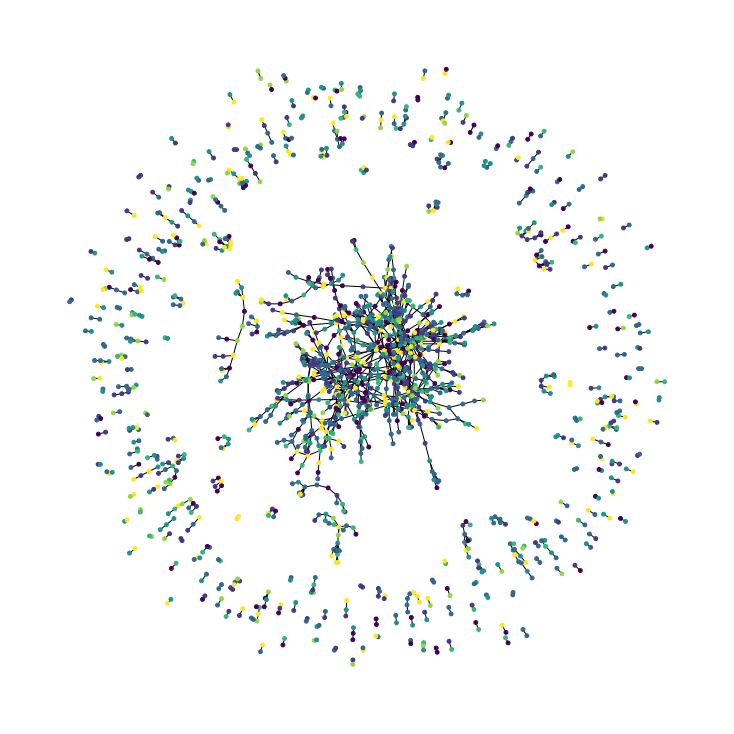

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


### Split the dataset into stratified train and test sets

In [12]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1319, 1435)
Test data shape: (1389, 1435)


## Implement Train and Evaluate Experiment

In [8]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

This function compiles and trains an input model using the given training data.

In [9]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    reduce_on_plateu = tf.keras.callbacks.ReduceLROnPlateau('val_acc')
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping, reduce_on_plateu],
    )

    return history


This function displays the loss and accuracy curves of the model during training.

In [10]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


## Build a Baseline Neural Network Model

### Prepare the data for the baseline model

In [13]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

  x_train - one hot encoding of terms. Let's check which terms contations second example: 

In [ ]:
x_train.shape

(1393, 1433)

### Implement a baseline classifier

We add five FFN blocks with skip connections, so that we generate a baseline model with
roughly the same number of parameters as the GNN models to be built later.

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 1433)]       0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 32)           52804       input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 32)           2368        ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 32)           0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

### Train the baseline classifier

In [ ]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 4s 137ms/step - loss: 6.1680 - acc: 0.1047 - val_loss: 1.9160 - val_acc: 0.2488
Epoch 2/300
5/5 [==============================] - 0s 29ms/step - loss: 2.7985 - acc: 0.2061 - val_loss: 1.9504 - val_acc: 0.2632
Epoch 3/300
5/5 [==============================] - 0s 29ms/step - loss: 2.7207 - acc: 0.2686 - val_loss: 1.9034 - val_acc: 0.2727
Epoch 4/300
5/5 [==============================] - 0s 30ms/step - loss: 2.3381 - acc: 0.2610 - val_loss: 1.8909 - val_acc: 0.3397
Epoch 5/300
5/5 [==============================] - 0s 35ms/step - loss: 2.0789 - acc: 0.2779 - val_loss: 1.8914 - val_acc: 0.3110
Epoch 6/300
5/5 [==============================] - 0s 27ms/step - loss: 2.0203 - acc: 0.2981 - val_loss: 1.8767 - val_acc: 0.3349
Epoch 7/300
5/5 [==============================] - 0s 26ms/step - loss: 1.8833 - acc: 0.2965 - val_loss: 1.8617 - val_acc: 0.3636
Epoch 8/300
5/5 [==============================] - 0s 24ms/step - loss: 1.7723 - acc: 0.3

Let's plot the learning curves.

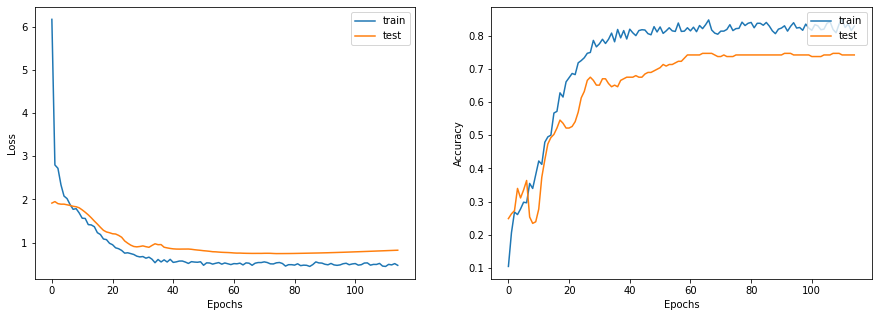

In [ ]:
display_learning_curves(history)

Now we evaluate the baseline model on the test data split.

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 74.75%


# Graph embeddings for baseline NN model

Let's encode structural information of graph into embeddings and try to feed this to the baseline model. Let's decode terms information to latent space of $R^{d}$ and then mix them with structural info of the model

## Node2Vec

In [ ]:
P = Q = 1
DIRECTED = True
NUM_WALKS = 13
WALK_LEN = 6
WINDOW_LEN = 5
LATENT_DIM_LEN = 300

Random walk graph implementation

In [ ]:
class Graph():
	def __init__(self, nx_G, is_directed, p, q):
		self.G = nx_G
		self.is_directed = is_directed
		self.p = p
		self.q = q

	def node2vec_walk(self, walk_length, start_node):
		'''
		Simulate a random walk starting from start node.
		'''
		G = self.G
		alias_nodes = self.alias_nodes
		alias_edges = self.alias_edges

		walk = [start_node]

		while len(walk) < walk_length:
			cur = walk[-1]
			cur_nbrs = sorted(G.neighbors(cur))
			if len(cur_nbrs) > 0:
				if len(walk) == 1:
					walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
				else:
					prev = walk[-2]
					next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
						alias_edges[(prev, cur)][1])]
					walk.append(next)
			else:
				break

		return walk

	def simulate_walks(self, num_walks, walk_length):
		'''
		Repeatedly simulate random walks from each node.
		'''
		G = self.G
		walks = []
		nodes = list(G.nodes())
		print('Walk iteration:')
		for walk_iter in range(num_walks):
			print(str(walk_iter+1), '/', str(num_walks))
			random.shuffle(nodes)
			for node in nodes:
				walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

		return walks

	def get_alias_edge(self, src, dst):
		'''
		Get the alias edge setup lists for a given edge.
		'''
		G = self.G
		p = self.p
		q = self.q

		unnormalized_probs = []
		for dst_nbr in sorted(G.neighbors(dst)):
			if dst_nbr == src:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
			elif G.has_edge(dst_nbr, src):
				unnormalized_probs.append(G[dst][dst_nbr]['weight'])
			else:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
		norm_const = sum(unnormalized_probs)
		normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

		return alias_setup(normalized_probs)

	def preprocess_transition_probs(self):
		'''
		Preprocessing of transition probabilities for guiding the random walks.
		'''
		G = self.G
		is_directed = self.is_directed

		alias_nodes = {}
		for node in G.nodes():
			unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
			norm_const = sum(unnormalized_probs)
			normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
			alias_nodes[node] = alias_setup(normalized_probs)

		alias_edges = {}
		triads = {}
		for edge in G.edges():
				if not is_directed:
						alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
				else:
						alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
						alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

		self.alias_nodes = alias_nodes
		self.alias_edges = alias_edges

		return

def alias_setup(probs):
	'''
	Compute utility lists for non-uniform sampling from discrete distributions.
	'''
	K = len(probs)
	q = np.zeros(K)
	J = np.zeros(K, dtype=np.int)

	smaller = []
	larger = []
	for kk, prob in enumerate(probs):
	    q[kk] = K*prob
	    if q[kk] < 1.0:
	        smaller.append(kk)
	    else:
	        larger.append(kk)

	while len(smaller) > 0 and len(larger) > 0:
	    small = smaller.pop()
	    large = larger.pop()

	    J[small] = large
	    q[large] = q[large] + q[small] - 1.0
	    if q[large] < 1.0:
	        smaller.append(large)
	    else:
	        larger.append(large)

	return J, q

def alias_draw(J, q):
	'''
	Draw sample from a non-uniform discrete distribution using alias sampling.
	'''
	K = len(J)

	kk = int(np.floor(np.random.rand()*K))
	if np.random.rand() < q[kk]:
	    return kk
	else:
	    return J[kk]

In [ ]:
# Read graph
weighted_citation = citations.copy()
weighted_citation['weight'] = 1
weighted_citation
nx_graph = nx.from_pandas_edgelist(weighted_citation, edge_attr=['weight'])
nx_graph.nodes.__len__()

2708

In [ ]:
# Make random walks
G = Graph(nx_graph, DIRECTED, P, Q)
G.preprocess_transition_probs()
walks = np.array(G.simulate_walks(NUM_WALKS, WALK_LEN))

Walk iteration:
1 / 13
2 / 13
3 / 13
4 / 13
5 / 13
6 / 13
7 / 13
8 / 13
9 / 13
10 / 13
11 / 13
12 / 13
13 / 13


In [ ]:
walks.shape

(35204, 6)

In [ ]:
# Hack to use Word2vec as Node2vec ^_^
walks_str = [list(map(str, walk)) for walk in walks if np.any(walk)]
model = gensim.models.Word2Vec(walks_str, size=LATENT_DIM_LEN, window=WINDOW_LEN)

node2vec_emb = np.empty((len(nx_graph.nodes()), LATENT_DIM_LEN))
for node in nx_graph.nodes():
  node2vec_emb[node] = model.wv[str(node)]

In [ ]:
node2vec_emb.shape

(2708, 300)

Let's build classifier on both node2vec embeddings and terms

In [ ]:
def create_graph_emb_model(terms_count, emb_dim, num_classes, dropout_rate=0.2):
    inputs_terms = layers.Input(shape=(terms_count,), name="input_terms")
    inputs_graph_emb = layers.Input(shape=(emb_dim,), name="input_graph_emb")
    x = create_ffn([int(terms_count / 2), int(terms_count / 3), emb_dim], dropout_rate, name=f"ffn_block1")(inputs_terms)
    # Add embeddings and recived term emb
    x = layers.Add()([x*1e-2, inputs_graph_emb])
    x = create_ffn([int(emb_dim / i) for i in range(2, 5)], dropout_rate, name=f"ffn_block4")(x)
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=[inputs_terms, inputs_graph_emb], outputs=logits, name="emb_graph_model")


graph_emb_model = create_graph_emb_model(x_train.shape[1], LATENT_DIM_LEN, num_classes, dropout_rate)
graph_emb_model.summary()

Model: "emb_graph_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_terms (InputLayer)        [(None, 1433)]       0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 300)          1522657     input_terms[0][0]                
__________________________________________________________________________________________________
tf.math.multiply_5 (TFOpLambda) (None, 300)          0           ffn_block1[0][0]                 
__________________________________________________________________________________________________
input_graph_emb (InputLayer)    [(None, 300)]        0                                            
____________________________________________________________________________________

In [ ]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)
idxs = papers['paper_id'].to_numpy()

# Create train and test features as a numpy array.
x_train_terms = train_data[feature_names].to_numpy()
x_train_emb = node2vec_emb[train_data['paper_id'].to_numpy()]
x_test_terms = test_data[feature_names].to_numpy()
x_test_emb = node2vec_emb[test_data['paper_id'].to_numpy()]
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [ ]:
x_train.shape, x_train_emb.shape

((1393, 1433), (1393, 300))

In [ ]:
history = run_experiment(graph_emb_model, [x_train_terms, x_train_emb], y_train)

Epoch 1/300
5/5 [==============================] - 3s 163ms/step - loss: 1.8331 - acc: 0.3590 - val_loss: 1.6311 - val_acc: 0.6364
Epoch 2/300
5/5 [==============================] - 0s 89ms/step - loss: 1.1390 - acc: 0.6233 - val_loss: 1.2732 - val_acc: 0.6938
Epoch 3/300
5/5 [==============================] - 0s 87ms/step - loss: 0.9734 - acc: 0.6951 - val_loss: 1.0800 - val_acc: 0.6938
Epoch 4/300
5/5 [==============================] - 0s 87ms/step - loss: 0.8285 - acc: 0.7424 - val_loss: 0.9977 - val_acc: 0.7081
Epoch 5/300
5/5 [==============================] - 0s 87ms/step - loss: 0.7700 - acc: 0.7483 - val_loss: 0.9482 - val_acc: 0.7129
Epoch 6/300
5/5 [==============================] - 0s 89ms/step - loss: 0.6873 - acc: 0.7897 - val_loss: 0.9329 - val_acc: 0.7177
Epoch 7/300
5/5 [==============================] - 0s 85ms/step - loss: 0.6264 - acc: 0.8032 - val_loss: 0.9086 - val_acc: 0.7081
Epoch 8/300
5/5 [==============================] - 0s 89ms/step - loss: 0.5349 - acc: 0.8

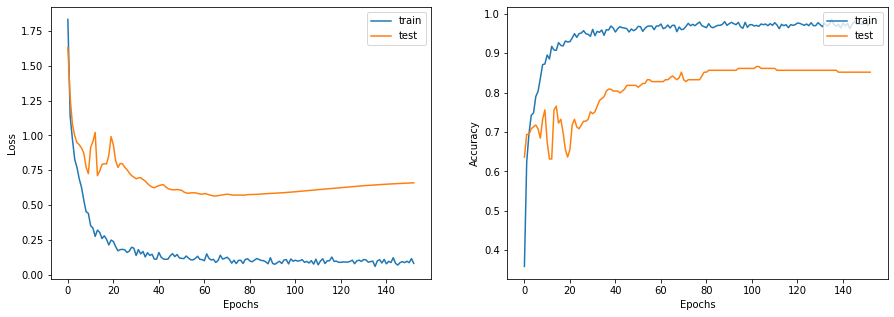

In [ ]:
display_learning_curves(history)

In [ ]:
_, test_accuracy = graph_emb_model.evaluate(x=[x_test_terms, x_test_emb], y=y_test, verbose=1)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


42/42 [==============================] - 0s 8ms/step - loss: 0.7718 - acc: 0.8304
Test accuracy: 83.04%


node2vec based model beat baseline on 10%!

## Conclusion

Graph structure is critical feature for node classification for the Cora dataset. Structure packed as node2vec embeddings improved results on 10%. It is possible to use random walks as a set of sentences and thus emloy all NLP specific embedders power to recieve better results on node classification task. One can try to train small transformer on random walks using MSE loss with adjacency  matrix as ground truth labels 